## First of all I loaded all the data into Snowflake database for easier manipulation
I made a simple datamart with snap dates '2020-09-01', '2020-09-08' for training
and '2020-09-15' for testing, datamart was exported in one csv file named
model_build_base.csv

#### The train set contains following data:
* 495,774 rows of SOLD=1 -> All transactions that were sold in week '2020-09-01' to '2020-09-07' and week '2020-09-08' to '2020-09-15'
* 4,000,000 randomly chosen combinations of customer_id and article_id that were not sold with SOLD=0
* All article information, customer information and customer transaction history info is also joined

#### The test set contains following data:
* Similar to train set just shifted forward for week between '2020-09-15' and '2020-09-22'



#### Fitting
A simple XGBoost model was fitted


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing custom library
!pip install git+https://github.com/Vrboska/mofr@master

  Cloning https://github.com/Vrboska/mofr (to revision master) to /tmp/pip-req-build-i7o0duww
  Running command git clone --filter=blob:none --quiet https://github.com/Vrboska/mofr /tmp/pip-req-build-i7o0duww
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Resolved https://github.com/Vrboska/mofr to commit 9e35370debae10d418189ddd58b213a64b210895
  Preparing metadata (setup.py) ... - done
  Created wheel for mofr: filename=mofr-1.0-py3-none-any.whl size=25810 sha256=95551192dcadca65daeeea7d9cb975d9889208576fbf5f93441f6ff65658d485
  Stored in directory: /tmp/pip-ephem-wheel-cache-wyv6axw2/wheels/b8/d0/2a/36bf0097c9fa72bb9af2b201e9b71bbfa6ebbae4fc8d066dc7
Successfully built mofr


In [3]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
import math

import xgboost as xgb

In [4]:
seed=1234

In [5]:
df=pd.read_csv('/kaggle/input/hm-model-build-base/model_build_base.csv')#.sample(100000)

In [6]:
df=df[df['ART_QUANTITY_SOLD_1M']>0]

In [7]:
len(df)

3217915

In [8]:
df.head()

,SOLD,SNAP_DATE,CUSTOMER_ID,ARTICLE_ID,ACTIVE,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,...,ART_DAYS_SINCE_LAST_PURCHASE,ART_AVERAGE_PRICE,ART_NUM_CHANNEL_2,CUSTART_QUANTITY_SOLD_1M,CUSTART_QUANTITY_SOLD_3M,CUSTART_QUANTITY_SOLD_12M,CUSTART_QUANTITY_SOLD_OVERALL,CUSTART_DAYS_SINCE_FIRST_PURCHASE,CUSTART_DAYS_SINCE_LAST_PURCHASE,CUSTART_NUM_CHANNEL_2
0,1,2020-09-08,9a7fa80c1a580081b4301a4d0a114485d5a76f6372bf63...,788575002,0.0,ACTIVE,NONE,22.0,0.0,0.0,...,0.0,0.040794,531.0,0.0,1.0,1.0,1.0,68.0,68.0,0.0
1,1,2020-09-08,f615c4137efbc8ab334c8b3d7e8f23135413ffcfc76979...,803468002,0.0,PRE-CREATE,NONE,34.0,0.0,0.0,...,0.0,0.024346,5115.0,2.0,2.0,3.0,3.0,219.0,19.0,3.0
2,1,2020-09-08,95d683ce18a86099b17b1ce179d75ea104c2dd2499e178...,895487001,0.0,ACTIVE,NONE,55.0,0.0,0.0,...,0.0,0.049347,188.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0
3,1,2020-09-15,a0600579fc60c7256793c471313d3cd2394267c091a672...,825437007,1.0,ACTIVE,Regularly,37.0,1.0,0.0,...,0.0,0.050522,32.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4,1,2020-09-15,230fdf2c5a903c504d256470ea69e0af5715746fa3f4a5...,888343003,0.0,ACTIVE,NONE,47.0,0.0,0.0,...,0.0,0.049718,476.0,1.0,1.0,1.0,1.0,9.0,9.0,0.0


In [9]:
train_mask=(df['SNAP_DATE']=='2020-09-08')|(df['SNAP_DATE']=='2020-09-01')
valid_mask=df['SNAP_DATE']=='2020-09-15'

In [10]:
df[train_mask]['SOLD'].value_counts()

0    1728198
1     438923
Name: SOLD, dtype: int64

In [11]:
df[valid_mask]['SOLD'].value_counts()

0    846254
1    204540
Name: SOLD, dtype: int64

# Data Exploration

In [12]:
df[train_mask].describe()

,SOLD,ARTICLE_ID,ACTIVE,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,QUANT_PG_COSMETIC_1M,QUANT_PG_FUN_1M,QUANT_PG_FURNITURE_1M,QUANT_PG_GFB_1M,...,ART_DAYS_SINCE_LAST_PURCHASE,ART_AVERAGE_PRICE,ART_NUM_CHANNEL_2,CUSTART_QUANTITY_SOLD_1M,CUSTART_QUANTITY_SOLD_3M,CUSTART_QUANTITY_SOLD_12M,CUSTART_QUANTITY_SOLD_OVERALL,CUSTART_DAYS_SINCE_FIRST_PURCHASE,CUSTART_DAYS_SINCE_LAST_PURCHASE,CUSTART_NUM_CHANNEL_2
count,2.167121e+06,2.167121e+06,2.167121e+06,2.157663e+06,2.167121e+06,2.167121e+06,2.167121e+06,2167121.0,2167121.0,2.167121e+06,...,2.167121e+06,2.167121e+06,2.167121e+06,19812.000000,19812.000000,19812.000000,19812.000000,19812.000000,19812.000000,19812.000000
mean,2.025374e-01,7.808831e+08,4.473913e-01,3.561032e+01,1.555972e-01,2.343201e-03,2.491785e-05,0.0,0.0,4.562205e-01,...,5.653073e+00,3.186357e-02,5.793902e+02,0.658591,0.844135,1.250454,1.464870,130.052544,111.151322,1.113568
std,4.018906e-01,1.262278e+08,4.972247e-01,1.387275e+01,6.375824e-01,5.184985e-02,6.075750e-03,0.0,0.0,1.785970e+00,...,8.081065e+00,2.384738e-02,1.633209e+03,0.896848,0.978614,1.258784,1.576328,181.069634,160.335660,1.295213
min,0.000000e+00,1.087750e+08,0.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,0.000000e+00,7.902267e-04,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,7.276160e+08,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,0.000000e+00,1.646464e-02,2.500000e+01,0.000000,0.000000,1.000000,1.000000,3.000000,3.000000,1.000000
50%,0.000000e+00,8.146020e+08,0.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,2.000000e+00,2.647438e-02,1.650000e+02,1.000000,1.000000,1.000000,1.000000,29.000000,22.000000,1.000000
75%,0.000000e+00,8.703450e+08,1.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,8.000000e+00,4.023079e-02,5.260000e+02,1.000000,1.000000,1.000000,1.000000,208.000000,177.000000,1.000000
max,1.000000e+00,9.534500e+08,1.000000e+00,9.600000e+01,2.600000e+01,3.000000e+00,2.000000e+00,0.0,0.0,8.900000e+01,...,3.100000e+01,5.060038e-01,4.186300e+04,57.000000,57.000000,57.000000,65.000000,719.000000,719.000000,57.000000


In [13]:
df[train_mask].describe(include=['O'])

,SNAP_DATE,CUSTOMER_ID,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,ART_PRODUCT_GROUP_NAME,COLOUR,ART_PERCEIVED_COLOUR,ART_INDEX_CODE
count,2167121,2167121,2167121,2167121,2167121,2167121,2167121,2167121
unique,2,133883,4,4,17,12,8,10
top,2020-09-01,65cb62c794232651e2ac711faa11c2b4e3d41d5f3b59b5...,ACTIVE,NONE,Garment Upper body,BLACK,Dark,A
freq,1094056,97,2139081,1175392,840933,580285,887777,756067


# Data transformations

In [14]:
col_target='SOLD'
col_exclude=[
'SNAP_DATE',
'CUSTOMER_ID',
'ARTICLE_ID',
# 'ART_DAYS_SINCE_FIRST_PURCHASE',
# 'ART_DAYS_SINCE_LAST_PURCHASE',

col_target,
    

]+[col for col in df.columns if 'CUSTART' in col]

In [15]:
col_exclude

['SNAP_DATE',
 'CUSTOMER_ID',
 'ARTICLE_ID',
 'SOLD',
 'CUSTART_QUANTITY_SOLD_1M',
 'CUSTART_QUANTITY_SOLD_3M',
 'CUSTART_QUANTITY_SOLD_12M',
 'CUSTART_QUANTITY_SOLD_OVERALL',
 'CUSTART_DAYS_SINCE_FIRST_PURCHASE',
 'CUSTART_DAYS_SINCE_LAST_PURCHASE',
 'CUSTART_NUM_CHANNEL_2']

## Categorical transformations

In [16]:
import category_encoders as ce

In [17]:
# potential predictors without encoding
cat_preds = [col for col in df.select_dtypes(include="object") if col not in col_exclude]
bool_preds = [col for col in df.select_dtypes(include="bool") if col not in col_exclude]
datetime_preds = [col for col in df.select_dtypes(include="datetime") if col not in col_exclude]

In [18]:
cat_preds

['CLUB_MEMBER_STATUS',
 'FASHION_NEWS_FREQUENCY',
 'ART_PRODUCT_GROUP_NAME',
 'COLOUR',
 'ART_PERCEIVED_COLOUR',
 'ART_INDEX_CODE']

### Target Encoding

In [19]:
# # bayesian target encoding
encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
encoder.fit_transform(df[train_mask][cat_preds], df[train_mask][col_target])

df = pd.concat([df, encoder.transform(df[cat_preds]).add_prefix("BAYES_")], axis=1)

In [20]:
col_preds=[col for col in df.select_dtypes(include=["int","float"]) if col not in col_exclude]

In [21]:
len(col_preds)

88

# Fitting models

In [22]:
(df[train_mask][col_target]>0).value_counts(normalize=True)

False    0.797463
True     0.202537
Name: SOLD, dtype: float64

## XGBoost model

## Fitting model

In [23]:
xgb_model = XGBClassifier(max_depth=4, seed=seed, colsample_bytree=0.5, gamma=1, min_child_weight=5, n_estimators=100)
xgb_model.fit(df[train_mask].loc[:, col_preds], df[train_mask][col_target], verbose=0, eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, reg_alpha=0, reg_lambda=1, ...)

In [24]:
df['XGB_SCORE']=xgb_model.predict_proba(df[col_preds])[:, 1]

In [25]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[train_mask][col_target], df[train_mask]['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[train_mask][col_target], df[train_mask]['XGB_SCORE'])))
print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(df[train_mask][col_target], df[train_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))

The Lift on the train set is: 4.030253179434439
The gini on the train set is: 0.8275626352645888
The accuracy on the train set is: 0.8750780413276416


The Lift on the valid set is: 4.093845794116494
The gini on the valid set is: 0.8262621772750414
The accuracy on the valid set is: 0.8763506453215378


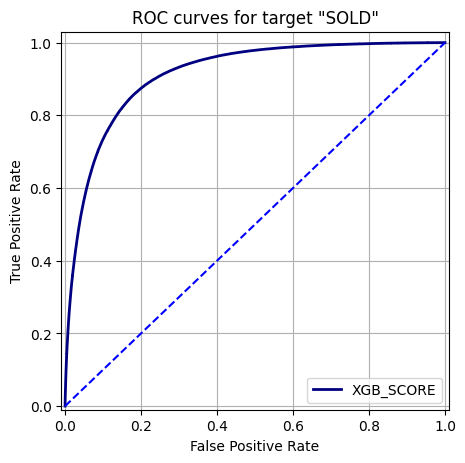

In [26]:
from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
df['one']=1

rce=ROCCurveEvaluator()
rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE'])
rce.get_graph()

del df['one']

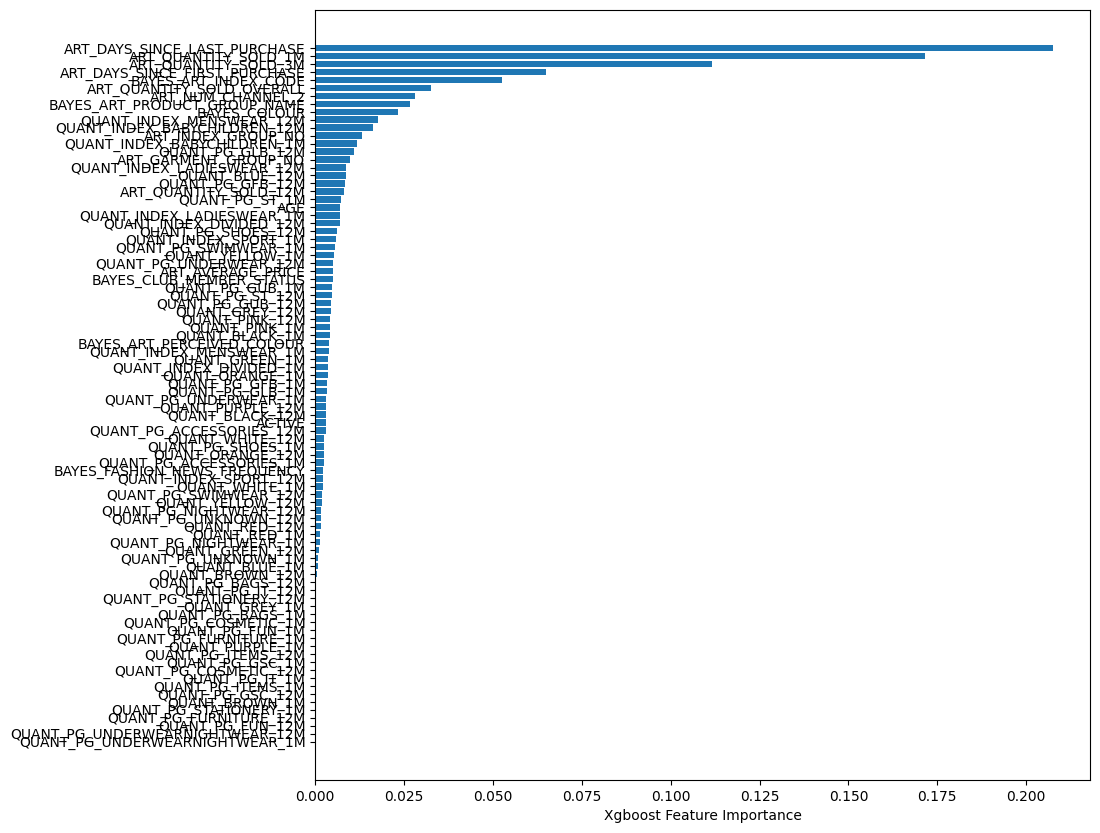

In [27]:
sorted_idx = xgb_model.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(col_preds[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [28]:
# results=[]
# for col in col_preds:
#     results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col]))))
  
# pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

### Saving the model

In [29]:
import pickle
file_name = "hm_xgb_model.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

In [30]:
import pickle
file_name = "hm_encoder.pkl"

# save
pickle.dump(encoder, open(file_name, "wb"))

# # load
# #encoder = pickle.load(open(file_name, "rb"))

## SHAP values

In [31]:
import shap  # package used to calculate Shap values

In [32]:
row_to_show = 1
data_for_prediction = df[train_mask][col_preds].iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

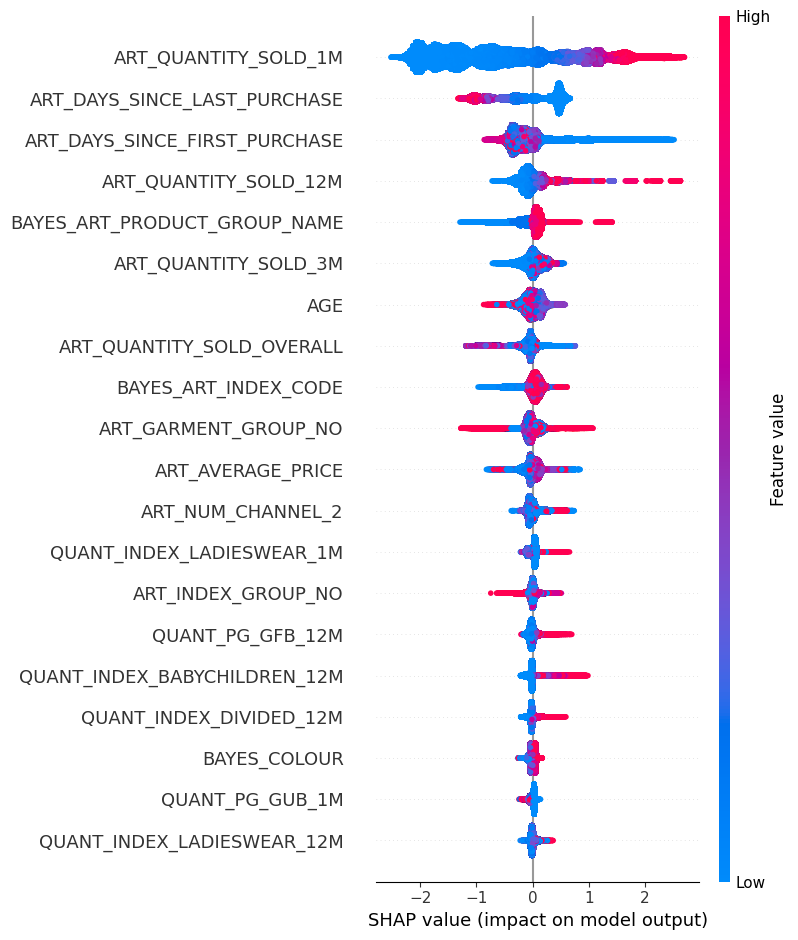

In [33]:
shap_values = explainer.shap_values(df[train_mask][col_preds])
shap.summary_plot(shap_values, df[train_mask][col_preds])

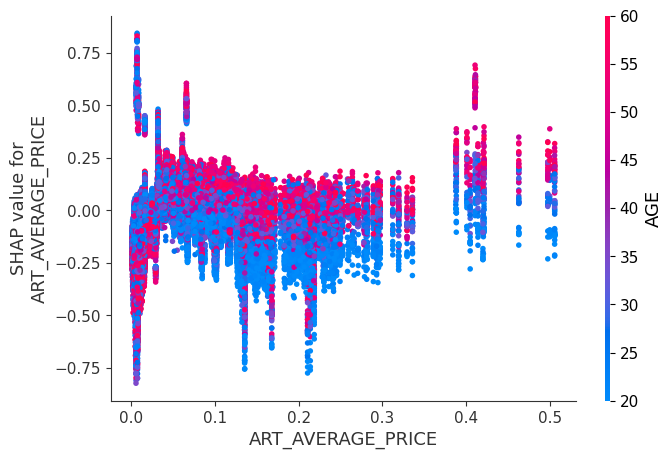

In [34]:
shap.dependence_plot('ART_AVERAGE_PRICE', shap_values, df[train_mask][col_preds], interaction_index="AGE")

# Future predictions part

Simple article preselection approach was chosen-> top 1000 articles by average XGB_SCORE 

In [35]:
del df

In [36]:
# import pickle
# file_name1= "hm_xgb_model.pkl"
# file_name2= "hm_encoder.pkl"

# # load
# xgb_model= pickle.load(open(file_name1, "rb"))
# encoder= pickle.load(open(file_name2, "rb"))

In [37]:
import pandas as pd

In [38]:
articles=pd.read_csv('/kaggle/input/hm-model-build-base/articles_predictions.csv')#.fillna(999)
customers=pd.read_csv('/kaggle/input/hm-model-build-base/customers_prediction.csv').fillna(0)

In [39]:
del customers['Unnamed: 0']

In [40]:
customers['CUSTOMER_ID10']=customers['CUSTOMER_ID'].apply(lambda x: x[0:10])

In [41]:
articles['ARTICLE_ID6']=articles['ARTICLE_ID'].apply(lambda x: int(str(x)[0:6]))

## Scoring customers in batches to produce submission file
For each of the 1000 suggested items and for each customer, then ordering and picking top 12

In [42]:
submission=pd.DataFrame()

In [43]:
def process_chunk(chunk):
    chunk=chunk.rename(columns={'CUSTOMER_ID':'CUSTOMER_ID10'}).drop_duplicates()
    chunk.drop_duplicates(subset=['CUSTOMER_ID10', 'ARTICLE_ID'], inplace=True)
    chunk=chunk.merge(articles, how='left', on='ARTICLE_ID')
    chunk=chunk.merge(customers, how='left', left_on='CUSTOMER_ID10', right_on='CUSTOMER_ID10')
    chunk = pd.concat([chunk, encoder.transform(chunk[cat_preds]).add_prefix("BAYES_")], axis=1)
    
    chunk['XGB_SCORE']=xgb_model.predict_proba(chunk[xgb_model.feature_names_in_])[:, 1]
    chunk['ARTICLE_ID']=chunk['ARTICLE_ID'].apply(str).apply(lambda x: x.zfill(10))
    a=chunk[['CUSTOMER_ID', 'ARTICLE_ID', 'XGB_SCORE']].groupby('CUSTOMER_ID').apply(lambda x : x.sort_values(by = 'XGB_SCORE', ascending = False).head(12).reset_index(drop = True)).reset_index(drop = True)
    b=pd.DataFrame(a.groupby('CUSTOMER_ID')['ARTICLE_ID'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'ARTICLE_ID':'PREDICTION'})
    return b

In [44]:
n=0
chunksize = 10 ** 6
with pd.read_csv('/kaggle/input/suggested-items/model_suggested_items.csv', chunksize=chunksize) as reader:
    for chunk in reader:
        print(f'{n}: {round(n/3.94,2)} % done')
        submission=pd.concat([submission,process_chunk(chunk)])
        n+=1

0: 0.0 % done
1: 0.25 % done
2: 0.51 % done
3: 0.76 % done
4: 1.02 % done
5: 1.27 % done
6: 1.52 % done
7: 1.78 % done
8: 2.03 % done
9: 2.28 % done
10: 2.54 % done
11: 2.79 % done
12: 3.05 % done
13: 3.3 % done
14: 3.55 % done
15: 3.81 % done
16: 4.06 % done
17: 4.31 % done
18: 4.57 % done
19: 4.82 % done
20: 5.08 % done
21: 5.33 % done
22: 5.58 % done
23: 5.84 % done
24: 6.09 % done
25: 6.35 % done
26: 6.6 % done
27: 6.85 % done
28: 7.11 % done
29: 7.36 % done
30: 7.61 % done
31: 7.87 % done
32: 8.12 % done
33: 8.38 % done
34: 8.63 % done
35: 8.88 % done
36: 9.14 % done
37: 9.39 % done
38: 9.64 % done
39: 9.9 % done
40: 10.15 % done
41: 10.41 % done
42: 10.66 % done
43: 10.91 % done
44: 11.17 % done
45: 11.42 % done
46: 11.68 % done
47: 11.93 % done
48: 12.18 % done
49: 12.44 % done
50: 12.69 % done
51: 12.94 % done
52: 13.2 % done
53: 13.45 % done
54: 13.71 % done
55: 13.96 % done
56: 14.21 % done
57: 14.47 % done
58: 14.72 % done
59: 14.97 % done
60: 15.23 % done
61: 15.48 % done
6

In [45]:
submission.drop_duplicates(subset='CUSTOMER_ID',keep='first', inplace=True, ignore_index=False)

In [46]:
submission.to_csv('submission.csv', index=False)